### Imports

In [51]:
import pandas as pd
import numpy as np

from pyhhmm.gaussian import GaussianHMM
from pandas_datareader.data import DataReader

import yfinance as yf
yf.pdr_override()

import matplotlib.pyplot as plt

In [52]:
# Data Extraction

start_date = '2017-01-01'
end_date = '2024-01-08'
symbol = 'BTC-usd'
data = DataReader(symbol, start_date, end_date) 

[*********************100%%**********************]  1 of 1 completed


In [53]:
# Manage Data and Add Features

data.drop(columns=['Close'], inplace=True)
df = data.copy()
df['returns'] = df['Adj Close']/df['Adj Close'].shift(1) - 1  
df['range'] = df['High']/df['Low'] -1

df.dropna(inplace=True)

df.head()

,Open,High,Low,Adj Close,Volume,returns,range
Date,,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023464,0.034803
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021620,0.022005
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.106233,0.110130
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,-0.122410,0.308302
2017-01-06,1014.239990,1046.810059,883.943970,902.200989,351876000,-0.109711,0.184249


In [54]:
# Structure Data for HMM

X_train = df[['returns', 'range']]
X_train.head()


,returns,range
Date,,
2017-01-02,0.023464,0.034803
2017-01-03,0.021620,0.022005
2017-01-04,0.106233,0.110130
2017-01-05,-0.122410,0.308302
2017-01-06,-0.109711,0.184249


### HMM Learning

In [55]:
# Fit HMM

model = GaussianHMM(n_states=4, covariance_type="full", n_emissions=2)
model.train([np.array(X_train.values)])

(<pyhhmm.gaussian.GaussianHMM at 0x1a4b30264c0>, 11729.191484493294)

In [56]:
# Check Results

hidden_states = model.predict([X_train.values])[0]
hidden_states[:30]

array([1, 1, 2, 3, 3, 3, 0, 0, 2, 3, 3, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 2])

In [57]:
# Regime state means for each feature
model.means

array([[-0.02537527,  0.05302698],
       [ 0.00499908,  0.02689396],
       [ 0.05087207,  0.07016167],
       [-0.01975388,  0.12717183]])

In [58]:
# Regime state covars for each feature
model.covars

array([[[ 5.36490781e-04, -3.44296610e-04],
        [-3.44296610e-04,  5.23302871e-04]],

       [[ 2.01836600e-04,  8.49789287e-05],
        [ 8.49789287e-05,  1.76430309e-04]],

       [[ 1.30932308e-03,  1.22663594e-03],
        [ 1.22663594e-03,  1.32887027e-03]],

       [[ 4.70691873e-03, -1.82003869e-03],
        [-1.82003869e-03,  4.86366184e-03]]])

### Data Visualization

In [59]:
# Structure Prices for plotting

prices = df['Adj Close'].values.astype(float)
print('Correct number of rows ', len(prices)==len(hidden_states))

i=0
labels_0 = []
labels_1 = []
labels_2 = []
labels_3 = []

for state in hidden_states:
    if state == 0:
        labels_0.append(prices[i])
        labels_1.append(np.nan)
        labels_2.append(np.nan)
        labels_3.append(np.nan)
    elif state == 1:
        labels_0.append(np.nan)
        labels_1.append(prices[i])
        labels_2.append(np.nan)
        labels_3.append(np.nan)
    elif state == 2:
        labels_0.append(np.nan)
        labels_1.append(np.nan)
        labels_2.append(prices[i])
        labels_3.append(np.nan)
    else:
        labels_0.append(np.nan)
        labels_1.append(np.nan)
        labels_2.append(np.nan)
        labels_3.append(prices[i])
    i+=1



Correct number of rows  True


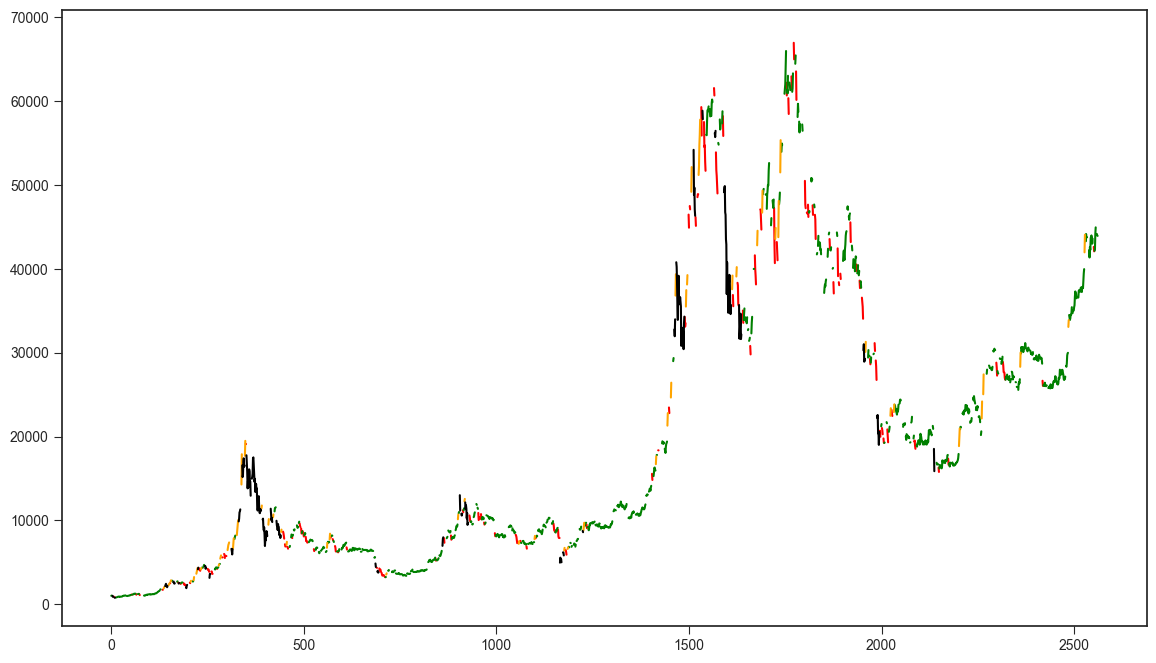

In [62]:
# Plot Results

fig = plt.figure(figsize=(14,8))
plt.plot(labels_0, color='red')
plt.plot(labels_1, color='green')
plt.plot(labels_2, color='orange')
plt.plot(labels_3, color='black')
plt.show()